In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.vector_ar.var_model import VARResults, VARProcess

from statsmodels.tsa.vector_ar.hypothesis_test_results import HypothesisTestResults

# Ejemplo obtenido de Lutkepohl

## Importar los datos

In [2]:
mdata = sm.datasets.macrodata.load_pandas().data

mdata.index = pd.period_range('1959-03-31', '2009-09-30', freq='Q')

mdata = mdata[['realgdp','realcons','realinv']]

data = np.log(mdata).diff().dropna()



In [3]:
data.head()

,realgdp,realcons,realinv
1959Q2,0.024942,0.015286,0.080213
1959Q3,-0.001193,0.010386,-0.072131
1959Q4,0.003495,0.001084,0.034425
1960Q1,0.022190,0.009534,0.102664
1960Q2,-0.004685,0.012572,-0.106694


## Gráficar las series

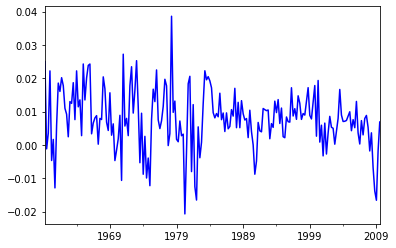

In [4]:
data['realgdp'].plot(color = 'b')
plt.show()

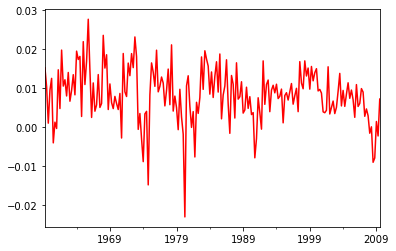

In [5]:
data['realcons'].plot(color = 'r')
plt.show()

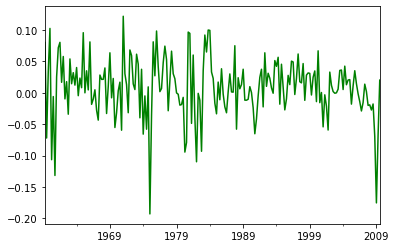

In [6]:
data['realinv'].plot(color = 'g')
plt.show()

In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [8]:
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "realgdp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9729
 No. Lags Chosen       = 1
 Critical value 1%     = -3.463
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "realcons" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.992
 No. Lags Chosen       = 2
 Critical value 1%     = -3.464
 Critical value 5%     = -2.876
 Critical value 10%    = -2.575
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "realinv" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

## Definir y estimar el VAR model

In [9]:
# make a VAR model
model = VAR(data)

## Seleccion de rezagos

In [10]:
model.select_order(maxlags=12).summary()

,AIC,BIC,FPE,HQIC
0,-27.72,-27.67,9.157e-13,-27.70
1,-28.05,-27.84*,6.596e-13,-27.96*
2,-28.05,-27.69,6.594e-13,-27.90
3,-28.06*,-27.54,6.542e-13*,-27.85
4,-28.04,-27.37,6.640e-13,-27.77
5,-28.03,-27.21,6.741e-13,-27.69
6,-27.98,-27.00,7.101e-13,-27.58
7,-27.94,-26.81,7.365e-13,-27.48
8,-27.94,-26.66,7.376e-13,-27.42
9,-27.97,-26.53,7.191e-13,-27.39


## Estimar el VAR

In [15]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, Aug, 2020
Time:                     14:57:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

In [12]:
# results = model.fit(maxlags=15, ic='aic')

In [ ]:
# results.plot_acorr()

## Analsis de residuos

En las secciones anteriores, hemos considerado procedimientos para elegir el orden de un modelo VAR para el proceso de generación de una serie de tiempo múltiple dada. Los criterios para la elección del modelo pueden considerarse criterios para decidir si los residuos están lo suficientemente cerca del ruido blanco. Por supuesto, si, por ejemplo, el pronóstico es el objetivo, puede no ser de suma importancia si los residuos son realmente ruido blanco siempre que el modelo pronostique bien.

Sin embargo, hay situaciones en las que resulta interesante comprobar el supuesto de ruido blanco  para los residuos de un modelo en particular. Por ejemplo, si el orden del modelo se elige por métodos no estadísticos (por ejemplo, sobre la base de alguna teoría económica), puede ser útil tener herramientas estadísticas disponibles para investigar las propiedades de los residuos.

In [16]:
# Ho: Residuals are white noise

results.test_whiteness(nlags=12).summary()

Test statistic,Critical value,p-value,df
108.2,113.1,0.093,90


## Normalidad de residuos

Se necesita la normalidad del proceso de generación de datos, por ejemplo, en la configuración de intervalos de pronóstico. Los residuos no normales también pueden indicar de manera más general que el modelo no es una buena representación del proceso de generación de datos. Por lo tanto, probar este supuesto de distribución es deseable. 

In [18]:
results.test_normality().summary()

Test statistic,Critical value,p-value,df
27.28,12.59,0.000,6


## Impulso Respuesta

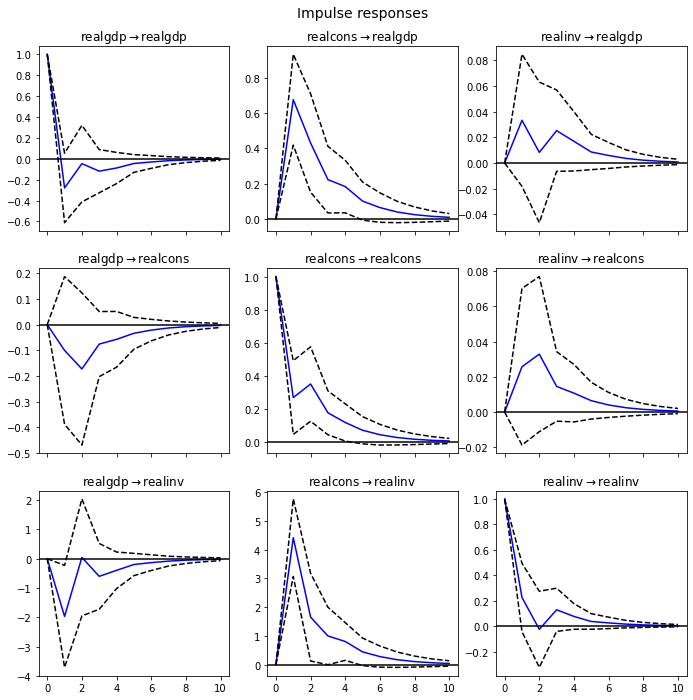

In [20]:
irf = results.irf(10)
irf.plot(orth=False)
plt.show()

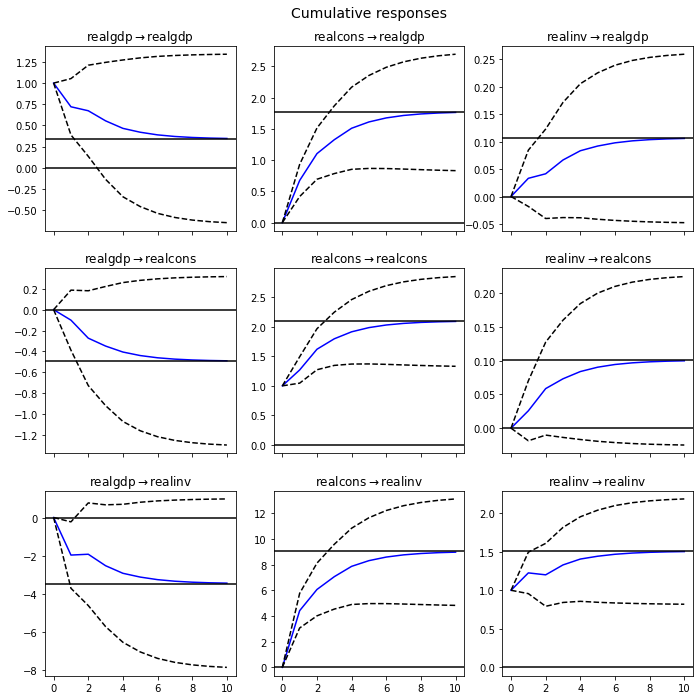

In [22]:
irf.plot_cum_effects(orth=False)
plt.show()

In [ ]:
# d=results.test_causality('realgdp', ['realinv', 'realcons'], kind='f')
# d.summary()

In [ ]:
# params = results.params
# endog_lagged = results.endog_lagged
# endog = results.endog
# sigma_u = results.sigma_u
# lag_order = results.k_ar
# exog = results.intercept

In [ ]:
# n =120

# y = np.zeros(n) 

# z = np.zeros(n) 
 

# for i in range(0,n):
    
#     εy = np.random.normal(0, 1, 1)
#     εz = np.random.normal(0, 1, 1)
    
#     e2 = εz
#     e1 = εy + 0.8*εz
    
    
#     y[i] = 0.7*y[i - 1] + 0.2*z[i-1]+ e1
    
#     z[i] = 0.2*y[i - 1] + 0.7*z[i-1]+ e2
    

# y = pd.Series(y)    

# z = pd.Series(z)

# frame = {'y':y,'z':z}

In [ ]:
# A1 = np.array([[0.7, 0.2],[0.2, 0.7]])
# B = np.array([[1, 0.8],[0, 1]])
# Binv = np.linalg.inv(B)
# B*A1

In [ ]:
# df = pd.DataFrame(frame) 
# df.index = pd.period_range('2001-01-01', '2010-12-01', freq='M')